# Zadanie nr 3 - Kompresja tekstu

In [99]:
from collections import defaultdict
from treelib import Tree
from heapq import heappush, heappop
from collections import Counter
from bitarray import bitarray, decodetree
from bitarray.util import *
from queue import Queue
import os
from random import shuffle
import numpy as np
import matplotlib.pyplot as plt
from time import time

Zadanie polega na implementacji dwóch algorytmów kompresji:

* statycznego algorytmu Huffmana
* dynamicznego algorytmu Huffmana

## 1. Statyczny algorytm Huffmana

In [1]:
class Node:
    def __init__(self, *args, **kwargs):
        self.weight = args[-1]
        self.elements = args[:-1]

    def __str__(self):
        string = ""
        for element in self.elements:
            string += str(element)
        return string

    def __repr__(self):
        return str(self)

    def __lt__(self, other):
        return self.weight < other.weight

In [2]:
def huffman(letter_counts):
    nodes = []
    for a, weight in letter_counts.items():
        nodes.append(Node(a, weight))

    internal_nodes = []
    leafs = sorted(nodes, key=lambda n: n.weight)

    while(len(leafs) + len(internal_nodes) > 1):
        element_1 = get_lowest_weight_node(leafs, internal_nodes)
        element_2 = get_lowest_weight_node(leafs, internal_nodes)

        internal_nodes.append(
            Node(element_1, element_2, element_1.weight + element_2.weight))

    return internal_nodes[0]


def get_lowest_weight_node(leafs, internal):
    if not internal or (leafs and leafs[0].weight < internal[0].weight):
        return leafs.pop(0)
    return internal.pop(0)

In [3]:
def huffman_heap(letter_counts):
    heap = []
    for a, weight in letter_counts.items():
        heappush(heap, Node(a, weight))

    while(len(heap) > 1):
        element_1 = heappop(heap)
        element_2 = heappop(heap)

        heappush(heap, Node(element_1, element_2,
                 element_1.weight + element_2.weight))

    return heappop(heap)

In [4]:
def get_codes(head):
    codes = {}
    head.code = ''

    def walk_tree(node):
        for i, child in enumerate(node.elements):
            child.code = node.code + str(i)

            if len(child.elements) > 1:
                walk_tree(child)
            else:
                codes[child.elements[0]] = bitarray(child.code)

    walk_tree(head)
    return codes

In [5]:
def show_tree(head):
    tree = Tree()
    tree.create_node(str(head) + ' weight: ' +
                     str(head.weight), head, parent=None)
    head.code = ''

    def create_tree(node):
        for i, child in enumerate(node.elements):
            child.code = node.code + str(i)
            tree.create_node(str(child) + ' weight: ' + str(child.weight) + ' code: ' + str(child.code),
                             child, parent=node)
            if len(child.elements) > 1:
                create_tree(child)

    create_tree(head)
    tree.show()

### kompresja i dekompresja

1. Opracować format pliku przechowującego dane.
2. Zaimplementować algorytm kompresji i dekompresji danych dla tego formatu pliku.

In [6]:
def encode(text, file):
    node = huffman(Counter(text))
    codes = get_codes(node)
    encoded_text = bitarray()
    encoded_text.encode(codes, text)

    mapping = bitarray()

    for letter, code in codes.items():
        letter_utf = bitarray()
        letter_utf.frombytes(letter.encode('utf-32'))
        # print(letter, letter_utf)

        code_len = bitarray()
        code_len.frombytes(len(code).to_bytes(1, 'big'))
        mapping += letter_utf + code_len + code

    letters_count = bitarray()
    letters_count.frombytes(len(codes).to_bytes(4, 'big'))
    text_bit_size = bitarray()
    text_bit_size.frombytes(len(encoded_text).to_bytes(4, 'big'))

    bit_seq = bitarray()
    bit_seq = letters_count + mapping + text_bit_size + encoded_text

    with open(file, 'wb') as f:
        bit_seq.tofile(f)


def decode(file):
    with open(file, 'rb') as f:
        bit_seq = bitarray()
        bit_seq.fromfile(f)

    letters_count = ba2int(bit_seq[:32])
    decode_dict = {}
    i = 32

    for _ in range(letters_count):
        # print(bit_seq[i:i+64])
        letter = bit_seq[i:i+64].tobytes().decode('utf-32')
        # print(letter)
        i += 64
        code_len = ba2int(bit_seq[i:i+8])
        i += 8
        code = bit_seq[i:i+code_len]
        i += code_len

        decode_dict[letter] = code

    text_len = ba2int(bit_seq[i:i+32])
    i += 32

    decode_tree = decodetree(decode_dict)
    text = ''.join(bit_seq[i:i+text_len].decode(decode_tree))
    return text

## 2. Dynamiczny algorytm Huffmana

## 3. Testy

3. Zmierzyć współczynnik kompresji (wyrażone w procentach: 1 - plik_skompresowany / plik_nieskompresowany) dla plików tekstowych o rozmiarach: 1kB, 10kB, 100kB, 1MB, dla różnych typów plików: plik tekstowy z portalu Guttenberga, plik źródłowy z Githubu, plik ze znakami losowanymi z rozkładu jednostajnego.

#### łańcuchy znaków do testów

In [36]:
# normal distribution random
alphabet = list(range(48, 126))
shuffle(alphabet)

with open('text_files/random_normal_full.txt', 'w') as f:
    for _ in range(5000000):
        random_index = round(np.random.normal(len(alphabet)//2, len(alphabet)//5))
        if random_index < 0 or random_index >= len(alphabet):
            continue
        f.write(chr(alphabet[random_index]))
        
!dd if=text_files/random_normal_full.txt of=text_files/random_normal_1MB.txt skip=0 count=11048576  iflag=skip_bytes,count_bytes
!dd if=text_files/random_normal_full.txt of=text_files/random_normal_100kB.txt skip=2048 count=102400  iflag=skip_bytes,count_bytes
!dd if=text_files/random_normal_full.txt of=text_files/random_normal_10kB.txt skip=4096 count=10240  iflag=skip_bytes,count_bytes
!dd if=text_files/random_normal_full.txt of=text_files/random_normal_1kB.txt skip=800 count=1024  iflag=skip_bytes,count_bytes

9674+1 records in
9674+1 records out
4953149 bytes (5,0 MB, 4,7 MiB) copied, 0,0230552 s, 215 MB/s
200+0 records in
200+0 records out
102400 bytes (102 kB, 100 KiB) copied, 0,000850192 s, 120 MB/s
20+0 records in
20+0 records out
10240 bytes (10 kB, 10 KiB) copied, 0,000526402 s, 19,5 MB/s
2+0 records in
2+0 records out
1024 bytes (1,0 kB, 1,0 KiB) copied, 0,000401524 s, 2,6 MB/s


In [39]:
sizes = ['1kB', '10kB', '100kB', '1MB']

# powieść z portalu Guttenberg
book_files = [f'text_files/anna_karenina_{size}.txt' for size in sizes]

books = []
for book_file in book_files:
    with open(book_file, 'r') as f:
        books.append(''.join(f).replace('#', '^'))
    
# linux source code
source_code_files = [f'text_files/source_code_{size}.c' for size in sizes]
source_codes = []
for source_file in source_code_files:
    with open(source_file, 'r') as f:
        source_codes.append(''.join(f).replace('#', '^'))
        

# normal distribution random
random_normal_files = [f'text_files/random_normal_{size}.txt' for size in sizes]
random_normals = []
for random_normal in random_normal_files:
    with open(random_normal, 'r') as f:
        random_normals.append(''.join(f).replace('#', '^'))
        
print(Counter(random_normals[0]))
print(random_normal[0])

Counter({'D': 38, 'b': 35, 'h': 34, '3': 32, 'X': 32, '?': 31, 'N': 29, '\\': 29, 'x': 29, 'A': 28, '8': 27, ';': 27, 'p': 26, 'M': 25, 'H': 23, 'k': 23, 'P': 23, '1': 23, 'Q': 23, 'J': 22, 'K': 22, 'R': 21, 'V': 18, 'l': 18, '2': 18, '{': 16, '>': 16, '=': 15, '^': 15, 'o': 15, '_': 15, '7': 14, 'd': 14, '0': 13, 'g': 13, 'Y': 13, 'u': 12, 'L': 11, 'q': 10, 'r': 10, '|': 10, 'a': 9, 'T': 9, ']': 9, 'B': 9, '5': 8, 'n': 8, 'e': 8, '9': 7, 'O': 7, 'S': 7, 'w': 7, 'F': 7, '}': 6, '`': 5, 'j': 5, 's': 4, '<': 4, '[': 4, ':': 4, 'f': 4, 'C': 4, 'y': 3, 'm': 3, 'z': 3, 'i': 2, 'Z': 2, '4': 2, 'W': 2, 'G': 2, 'c': 1, '@': 1})
t


In [40]:
def get_compression_rate(file, text):
    file_size = os.path.getsize(file)
    encode(text, 'encoded')
    encoded_size = os.path.getsize('encoded')
    return encoded_size/file_size

In [97]:
def plot_compression_rate(rates_info, title, sizes):
    fig, ax = plt.subplots(1, len(rates_info), figsize=(12, 5))
    
    for i, rates in enumerate(rates_info):
        ax.set_title(title)
        ax.bar(sizes, rates[0], color='tan')

--text_files/anna_karenina--
STATIC HUFFMAN COMPRESSION
1kB: 97.363281%
10kB: 60.341797%
100kB: 55.174805%
1MB: 54.174805%

--text_files/source_code--
STATIC HUFFMAN COMPRESSION
1kB: 123.046875%
10kB: 70.175781%
100kB: 64.644531%
1MB: 65.202045%

--text_files/random_normal--
STATIC HUFFMAN COMPRESSION
1kB: 142.773438%
10kB: 81.494141%
100kB: 74.766602%
1MB: 74.090321%



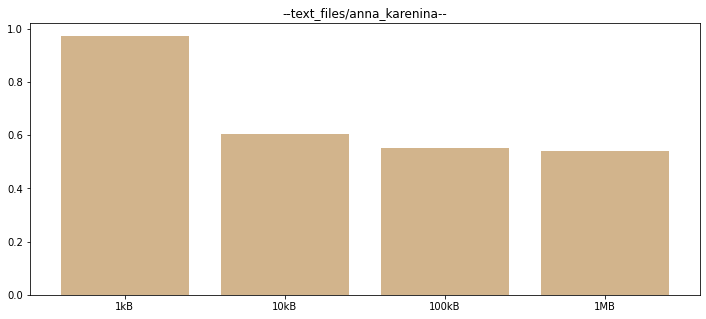

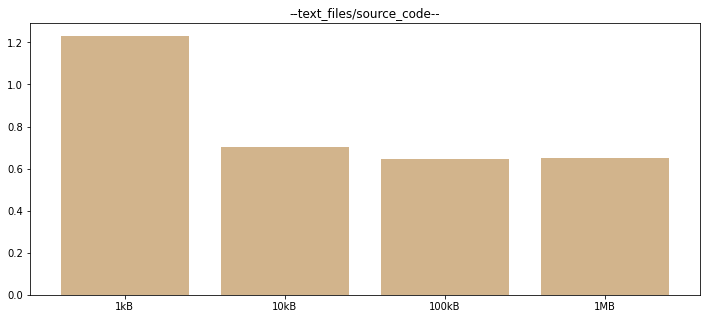

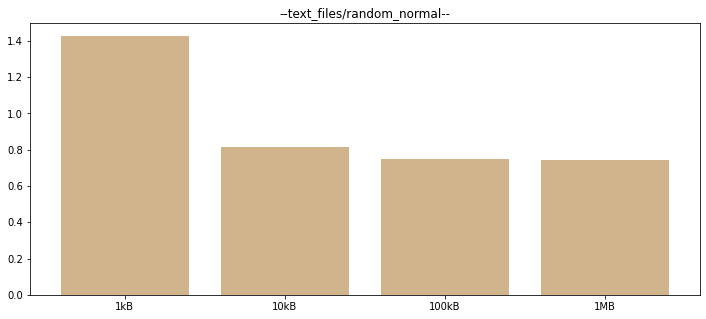

In [98]:
for files, texts in zip([book_files, source_code_files, random_normal_files], [books, source_codes, random_normals]):
    file_type = f'--{"_".join(files[0].split("_")[:3])}--'
    print(file_type)
    
    print('static huffman compression'.upper())
    rates_static = []
    for i, size in enumerate(sizes):
        rates_static.append(get_compression_rate(files[i], texts[i]))
        print(f'{size}: {rates_static[-1]:%}')
    
    plot_compression_rate([[rates_static, 'static']], file_type, sizes)
    print()

4. Zmierzyć czas kompresji i dekompresji dla plików z punktu 3 dla każdego algorytmu.

In [101]:
def count_time(text):
    encode_start = time()
    encode(text, 'encoded')
    encode_end = time()
    
    decode_start = time()
    decode('encoded')
    decode_end = time()
    
    return encode_end - encode_start, decode_end - decode_start

In [119]:
def plot_time(encode_time, decode_time, title, sizes):
    fig, ax = plt.subplots(1, 1, figsize=(12, 5))
    
    ax.set_title(title)
    ax.bar(sizes, encode_times, color='mediumturquoise')
    ax.bar(sizes, decode_times, bottom=encode_times, color='aquamarine')
    ax.legend(labels=["encoding", "decoding"])
    
    plt.show()

--text_files/anna_karenina--
STATIC HUFFMAN COMPRESSION
1kB: encoding: 0.00073 decoding: 0.00037
10kB: encoding: 0.00221 decoding: 0.00073
100kB: encoding: 0.00867 decoding: 0.00405
1MB: encoding: 0.08213 decoding: 0.03808


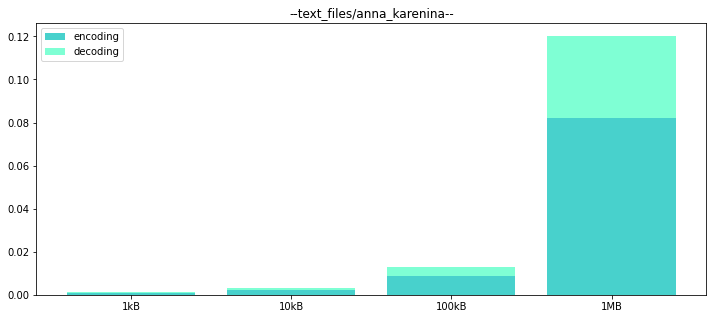


--text_files/source_code--
STATIC HUFFMAN COMPRESSION
1kB: encoding: 0.00097 decoding: 0.00025
10kB: encoding: 0.00158 decoding: 0.00070
100kB: encoding: 0.00944 decoding: 0.00423
1MB: encoding: 0.08799 decoding: 0.03851


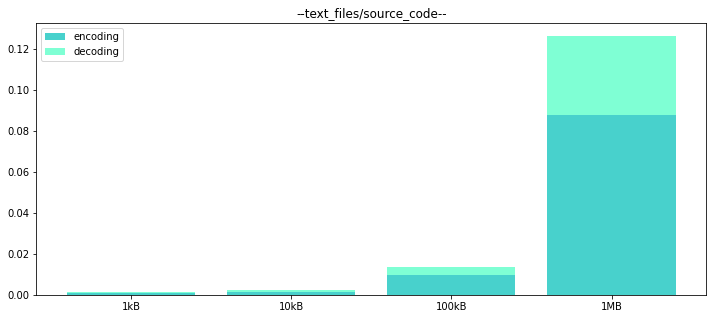


--text_files/random_normal--
STATIC HUFFMAN COMPRESSION
1kB: encoding: 0.00087 decoding: 0.00025
10kB: encoding: 0.00162 decoding: 0.00074
100kB: encoding: 0.00974 decoding: 0.00461
1MB: encoding: 0.41395 decoding: 0.23124


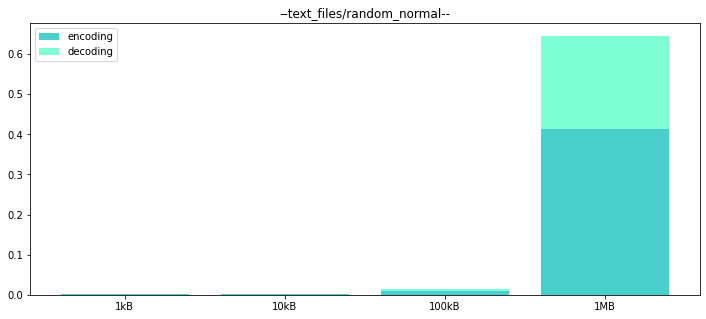

In [120]:
for files, texts in zip([book_files, source_code_files, random_normal_files], [books, source_codes, random_normals]):
    file_type = f'--{"_".join(files[0].split("_")[:3])}--'
    print(file_type)
    
    print('static huffman compression'.upper())
    encode_times = []
    decode_times = []
    
    for i, size in enumerate(sizes):
        encode_time, decode_time = count_time(texts[i])
        encode_times.append(encode_time)
        decode_times.append(decode_time)
        print(f'{size}: encoding: {encode_time:.5f} decoding: {decode_time:.5f}')
    plot_time(encode_times, decode_times, file_type, sizes)
        
    print()

## 4. Wnioski

- 
- 

M. Hawryluk 23.04.2021